## Загрузка пакетов

In [1]:
import numpy as np
import pandas as pd
import random
import ipywidgets

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import style as style
style.use("ggplot")

In [2]:
matplotlib.rcParams.update({'font.size': 14})

## Загрузка функций

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Загрузка классов

In [5]:
class Preprocessing:
    """
    Класс для подготовки данных датасета
    """
    
    def distribution(self, df):
        """
        Интерактивный график для просмотра целевой переменной или выбросов в данных
        """
        self.df = df
        
        @ipywidgets.interact(column = self.df.columns, bins=(10, 300, 10))
        def distribution_plot(bins=30, column='Price'):
            plt.figure(figsize=(16, 9))

            self.df[column].hist(bins=bins)
            plt.ylabel('Count')
            plt.xlabel(column)
            plt.title('Distribution')
        
        
    def drop_feature(self, df, column):
        """
        Отбрасываем ненужные столбцы
        """        
        df = df.drop(column, axis =1)
        
        return df
    
    
    def rooms(self, df):
        """
        Обработка выбросов количества комнат
        """
        
        self.median = df['Rooms'].median()
        
        df.loc[(df['Rooms'] > 6) | (df['Rooms'] < 1), 'Rooms'] = self.median
        
        
    def preproc_quantile(self, df, column):
        """
        Обработка выбросов площади
        """
        self.median = df[column].median()

        
        df.loc[(df[column] > df[column].quantile(.975)) |
        (df[column] < df[column].quantile(.025)), column] = self.median
        
        if column == 'KitchenSquare':
            df.loc[df[column] < 3, column] = self.median
            
        if column == 'LifeSquare':
            df.loc[df[column].isnull(), column] = self.median
        
        
        
    def preproc_floor(self, df):
        """
        Обработка выбросов количества этажей
        """
        preproc_floor = df.loc[df['Floor'] > df['HouseFloor']].index
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
        df.loc[preproc_floor, 'Floor'] = df.loc[preproc_floor, 'HouseFloor'].apply(lambda x: random.randint(0, x))
        
        
    def preproc_social_1(self, df):
        """
        Обработка выбросов социальных параметров
        """
        self.social_1 = df['Social_1'].median()
          
        
        df.loc[(df['Social_1'] == 0) | (df['Social_1'] >= 60), 'Social_1'] = self.social_1
        
    def factorize_feat(self, data):
        """
        Перевод категориальных данных в численные
        """
        pd.factorize(data)[0]
        
    
    def preproc_shops(self, df):
        """
        Обработка выбросов в фиче Shops_1
        """
        df.loc[df['Shops_1'] == 16, 'Shops_1'] = df['Shops_1'].median()

prep = Preprocessing()

## Загрузка датасета

In [6]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

## Оптимизация памяти

In [8]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [9]:
reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698120,94.521461,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


## Обзор данных до обработки

In [10]:
prep.distribution(train_df)

interactive(children=(IntSlider(value=30, description='bins', max=300, min=10, step=10), Dropdown(description=…

## Отбрасывание признаков

_Отбрасываем Healthcare_1, т.к. в последнем много пропусков._

In [11]:
train_df = prep.drop_feature(train_df, 'Healthcare_1')
test_df = prep.drop_feature(test_df, 'Healthcare_1')

## Изменение типов данных

_Изменяем тип данных DistrictId и Id на строковый._

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
test_df['Id'] = test_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

_Изменяем тип данных Ecology_2 с категорий на числа_

In [13]:
train_df['Ecology_2'] = pd.factorize(train_df['Ecology_2'])[0]
test_df['Ecology_2'] = pd.factorize(test_df['Ecology_2'])[0]

## Обработка выбросов и пропусков

_Обрабатываем выбросы в количестве комнат по условию, что количество комнат больше 6 или меньше 1._

In [14]:
prep.rooms(train_df)
prep.rooms(test_df)

_Обрабатываем выбросы в площади кухни по квантилям: заполняем медианой значения, не превышающие .025 квантиль и превышающие .975 квантиль медианой значений, а также заполняем пропуски в фиче LifeSquare и заполняем нули значением 3 в параметре KitchenSquare._

In [15]:
prep.preproc_quantile(train_df, 'Square')
prep.preproc_quantile(train_df,'LifeSquare')
prep.preproc_quantile(train_df, 'KitchenSquare')
prep.preproc_quantile(test_df, 'Square')
prep.preproc_quantile(test_df,'LifeSquare')
prep.preproc_quantile(test_df, 'KitchenSquare')

_Обрабатываем выбросы и логические несоответствия в параметрах Floor и HouseFloor: этаж квартиры не может быть выше этажа дома, исправляем. А также заполняем нулевые этажи квартир медианой фичи._

In [16]:
prep.preproc_floor(train_df)
prep.preproc_floor(test_df)

_Обрабатываем выбросы параметров Social:_

In [17]:
prep.preproc_social_1(train_df)
train_df = train_df[train_df['Social_2'] < 12000]
train_df = train_df[train_df['Social_3'] < 40]
prep.preproc_social_1(test_df)

_Обрабатываем выбросы параметров Shops:_

In [18]:
prep.preproc_shops(train_df)
prep.preproc_shops(test_df)

## Обзор данных после обработки

In [19]:
prep.distribution(train_df)

interactive(children=(IntSlider(value=30, description='bins', max=300, min=10, step=10), Dropdown(description=…

## Построение модели

_Выбираем признаки для модели, разбиваем модель на тренировочную и тестовую группу:_

In [20]:
feat = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'Ecology_1', 
        'Ecology_2', 'Social_1', 'Social_3', 'Shops_1', 'Helthcare_2']
x = train_df[feat]
y = train_df['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.16, random_state = 42)

_Определяем класс для обучения. Параметры определены с помощью GridSearchCV._

In [21]:
forest = RandomForestRegressor(n_estimators=200, max_depth=16)
forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=16, n_estimators=200)

_Тренируем модель и смотрим результаты:_

Train R2:	0.948
Test R2:	0.739


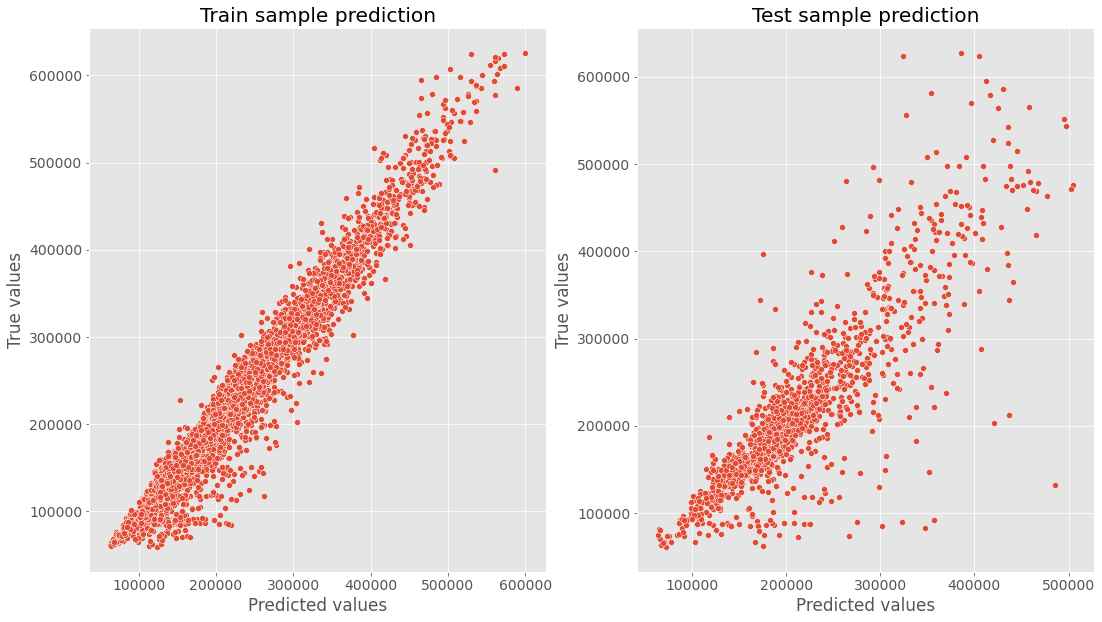

In [22]:
train_pred = forest.predict(x_train)
fin_test = x_test[feat]
test_pred = forest.predict(fin_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

## Итоговое предсказание

_Проводим итоговое предсказание:_

In [29]:
exam_pred = test_df[feat]
exam_pred = exam_pred.fillna(0)
pred = pd.DataFrame(data=forest.predict(exam_pred), index=test_df['Id'], columns=['Price'])

_Сохраняем в .csv_

In [30]:
pred.to_csv('Kanushin_predictions.csv')